In [1]:
"""Demonstrate particle-resolved Brownian coagulation.

Generates a modest bimodal particle-resolved sample, configures Brownian
coagulation with ``distribution_type="particle_resolved"``, runs a short
step, and plots histograms of radii before/after execution to show how the
sample redistributes. Uses a small sample size to keep runtime fast.

Example:
    Run the script to visualize how Brownian coagulation redistributes a
    set of sampled radii in a particle-resolved representation via the
    public ``par.dynamics`` API.
"""

'Demonstrate particle-resolved Brownian coagulation.\n\nGenerates a modest bimodal particle-resolved sample, configures Brownian\ncoagulation with ``distribution_type="particle_resolved"``, runs a short\nstep, and plots histograms of radii before/after execution to show how the\nsample redistributes. Uses a small sample size to keep runtime fast.\n\nExample:\n    Run the script to visualize how Brownian coagulation redistributes a\n    set of sampled radii in a particle-resolved representation via the\n    public ``par.dynamics`` API.\n'

# Coagulation Pattern 3: Particle Resolved

Brownian coagulation using the public `par.dynamics` API with a
particle-resolved representation:

1. Build a Brownian coagulation strategy with
   `distribution_type="particle_resolved"`.
2. Wrap it in `par.dynamics.Coagulation`.
3. Run a short, fast step on a sampled aerosol and visualize the change.

In [2]:
# In Colab uncomment the following command to install particula:
#!pip install particula[extra] --quiet
import matplotlib.pyplot as plt
import numpy as np
import particula as par

## Build a particle-resolved aerosol

Sample a modest bimodal lognormal distribution, assign mass/density, and
combine with a simple atmosphere.

In [3]:
# Sample radii (small sample for speed)
radii_sample = par.particles.get_lognormal_sample_distribution(
    mode=np.array([80e-9, 200e-9]),
    geometric_standard_deviation=np.array([1.4, 1.5]),
    number_of_particles=np.array([4e3, 2e3]),
    number_of_samples=12_000,
)

density = np.array([1_000.0])
mass_sample = 4 / 3 * np.pi * radii_sample**3 * density

# Atmosphere (ambient)
atmosphere = (
    par.gas.AtmosphereBuilder()
    .set_temperature(25, "degC")
    .set_pressure(1, "atm")
    .build()
)

# Particle-resolved representation
particles_resolved = (
    par.particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(par.particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(par.particles.ActivityIdealMass())
    .set_surface_strategy(par.particles.SurfaceStrategyVolume())
    .set_mass(mass_sample, mass_units="kg")
    .set_density(density, density_units="kg/m^3")
    .set_charge(0)
    .set_volume(1e-3, volume_units="m^3")
    .build()
)

aerosol_resolved = par.Aerosol(
    atmosphere=atmosphere, particles=particles_resolved
)

## Configure coagulation (particle_resolved)

In [4]:
coagulation_strategy = (
    par.dynamics.BrownianCoagulationBuilder()
    .set_distribution_type("particle_resolved")
    .build()
)
coagulation_process = par.dynamics.Coagulation(
    coagulation_strategy=coagulation_strategy
)

print(coagulation_process)

## Execute a short coagulation step

In [5]:
time_step = 200  # seconds
sub_steps = 5

radii_before = aerosol_resolved.particles.get_radius()

aerosol_after = coagulation_process.execute(
    aerosol_resolved, time_step=time_step, sub_steps=sub_steps
)
radii_after = aerosol_after.particles.get_radius()

## Plot: particle-resolved histogram before/after

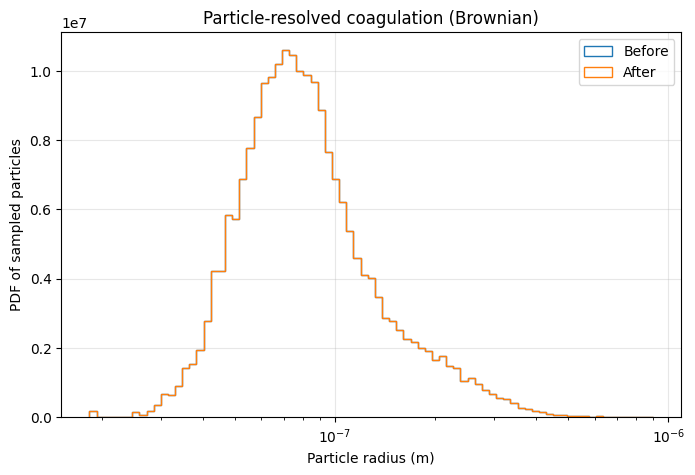

In [6]:
bins = np.logspace(
    np.log10(radii_before.min()), np.log10(radii_before.max()), 80
).tolist()

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(
    radii_before,
    bins=bins,
    histtype="step",
    color="tab:blue",
    label="Before",
    density=True,
)
ax.hist(
    radii_after,
    bins=bins,
    histtype="step",
    color="tab:orange",
    label="After",
    density=True,
)
ax.set_xscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("PDF of sampled particles")
ax.set_title("Particle-resolved coagulation (Brownian)")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

## Summary

- Strategy: `BrownianCoagulationBuilder().set_distribution_type("particle_resolved")`
- Runnable: `par.dynamics.Coagulation`
- Representation: particle-resolved sampled radii/mass
- Runtime guardrails: ~12k samples, short horizon, few sub-steps